In [ ]:
#@title **Information**
%%html
<marquee style='width: 50%; color: white;'><b>Dylan Govender (221040222) - COMP700</b></marquee>

#**Abstract**

Lung cancer is a significant contributor to cancer-related mortality. With recent advancements in Computer Vision, Vision Transformers have gained traction and shown remarkable success in medical image analysis. This study explored the potential of Vision Transformer models (ViT, CVT, CCT ViT, Parallel ViT, Efficient ViT) compared to established state-of-the-art architectures (CNN) for lung cancer detection via medical imaging modalities, including CT and Histopathological scans. This work evaluated the impact of data availability and different training approaches on model performance. The training approaches included but were not limited to, Supervised Learning and Transfer Learning. Established evaluation metrics such as accuracy, recall, precision, F1-score, and area under the ROC curve (AUC-ROC) assessed model performance in terms of detection efficacy, data validity, and computational efficiency. ViT achieved an accuracy of 94% on a balanced dataset and an accuracy of 87% on an imbalanced dataset trained from the ground up. Cost-sensitive evaluation metrics, such as cost matrix and weighted loss, analysed model performance by considering the real-world implications of different types of errors, especially in cases where misdiagnosing a cancer case is far more critical.

# **Vision Transformer from Scratch on Lung Cancer CT Scan Images**

In this notebook, we are going to train various Vision Transformer (ViT) Models (including interesting variants) from scratch on the [The IQ-OTH/NCCD lung cancer dataset](https://www.kaggle.com/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset/code). This dataset contains a total of 1190 images representing CT scan slices of 110 lung cancer cases. These cases are grouped into three classes: normal, benign, and malignant. Of these, 40 cases are diagnosed as malignant; 15 cases diagnosed with benign; and 55 cases classified as normal cases.

We will prepare the data using [The IQ-OTH/NCCD lung cancer dataset](https://www.kaggle.com/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset/code), and train the model using [PyTorch Lightning](https://github.com/PyTorchLightning/pytorch-lightning).

## **Quick Introduction: Vision Transformer (ViT) by Google Brain**

The Vision Transformer (ViT) is basically BERT, but applied to images. This research will see how the ViT compares to state-of-the-art (SOTA) CNN Models. In order to provide images to the model, each image is split into a sequence of fixed-size patches (typically of resolution 16x16 or 32x32), which are linearly embedded. Additionally, we can add a [CLS] token at the beginning of the sequence in order to classify images. Next, we can add an absolute position embedding which provides this sequence to the Transformer Encoder.

* Paper: https://arxiv.org/abs/2010.11929
* Official repo (in JAX): https://github.com/google-research/vision_transformer

<br></br>
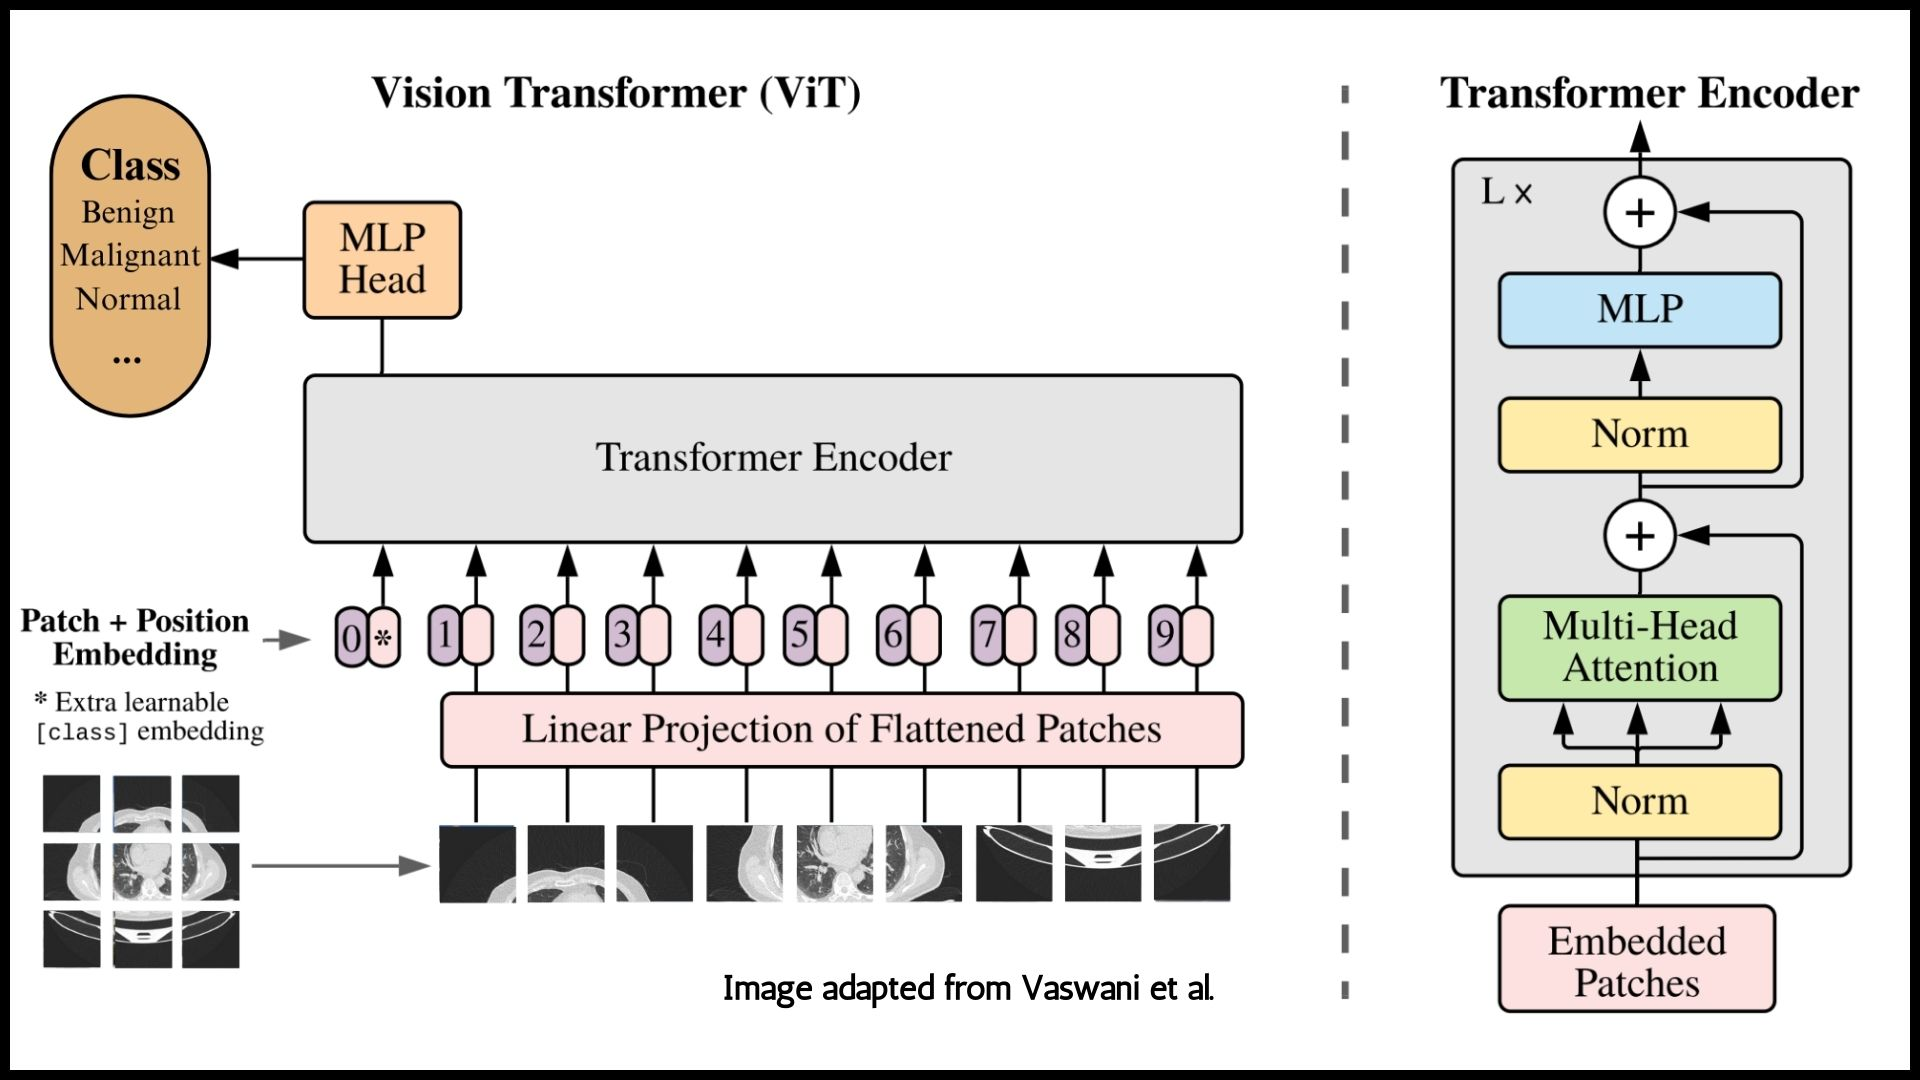

## **Problem Area**
Lung cancer is a leading cause of cancer-related mortality. Traditional diagnostic methods rely heavily on radiologists' expertise, which can be prone to human error and variability. Early detection is critical for improving patient outcomes.

<br></br>
## **Solution**
Addressing the need for more accurate and reliable automated tools for lung cancer detection through medical imaging. The study specifically explores the potential of Vision Transformer (ViT) models and compares their performance to state-of-the-art deep learning architectures, Convolutional Neural Networks (CNN), in detecting lung cancer from medical imaging modalities, including CT and histopathological scans.

<br></br>
## **Research Gap**
* Imaging Modalities
* Data Augmentation and Efficiency
* Training Techniques
* Single Transformer Encoder
* Hybrid Architectures
* Cost-Sensitive Evaluation
* Efficient Vision Transformer

<br></br>
## **Objectives**
✅ Evaluation of Vision Transformers <br>
✅ Comparison with SOTA Architectures <br>
✅ Assess the Role of Data <br>
✅ Assess Training Techniques <br>
✅ Evaluate Cost-Sensitive Metrics <br>
✅ Explore Data Scarcity Solutions <br>
✅ Optimise for Cost-Effectiveness <br>
✅ Analyse Multi-Modal Generalisation <br>

<br></br>
## **Aims**
✅ Improve Diagnostic Accuracy in Lung Cancer Detection <br>
✅ Establish the Suitability of Vision Transformer in Clinical Practice <br>
✅ Minimise the Impact of Data Limitations on Model Performance <br>
✅ Promote Reliable Cancer Detection with Cost-Sensitive Approaches <br>
✅ Advance Knowledge on ViT Applications in Medical Imaging <br>
✅ Lay the Foundation for Future Research <br>

<br></br>
## **Background: What are Transformers?**
The first sequence transduction model based entirely on attention. In NLP, a model might take a sequence of words (input) and convert it into another sequence of words (output), such as in machine translation. Transformers were introduced in the paper “Attention is all you need.” by Vaswani et al. Transformer, is a self attention-based mechanism prominently used for Natural
Language Processing (NLP) and later adapted for Computer Vision, leading to the Vision Transformer's (ViT) development. ViT, the new deep-learning architecture, has emerged as a potent tool for medical image analysis, particularly for image classification, offering a new horizon of possibilities in this field.

<br></br>
## **Datasets**
* [**IQ OTH/NCCD Dataset**](https://www.kaggle.com/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset/code) by Alyasriy et al. is an imbalanced small dataset and provides CT scan images of three classes: normal, malignant, and benign.
* [**Histopathological Lung Cancer Dataset**](https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images) by Borkowski et al. is a perfectly balanced large dataset that uses histopathological images with three defined classes provided.



# **1. Downloading Dependencies and Data**

In [ ]:
#@title **1.1 Downloading Dependencies**

# for capturing output
%%capture

# Dependencies
!pip install transformers
!pip install datasets
!pip install pytorch-lightning
!pip install torchmetrics

In [ ]:
#@title **1.2 Downloading Data**

# for capturing output
%%capture

# Data
!cp '/content/drive/MyDrive/Honours Project/Datasets/IQ-OTHNCCD_Lung_Cancer_Dataset.zip' 'IQ-OTHNCCD_Lung_Cancer_Dataset.zip'
!unzip '/content/IQ-OTHNCCD_Lung_Cancer_Dataset.zip'
!rm '/content/IQ-OTHNCCD_Lung_Cancer_Dataset.zip'

# **2. Importing the Data**

In [ ]:
#@title **2.1 Extracting the data.**

import os
import pandas as pd
import matplotlib.pyplot as plt

normal_dir = "/content/The IQ-OTHNCCD lung cancer dataset/Normal cases"
benign_dir = "/content/The IQ-OTHNCCD lung cancer dataset/Bengin cases"
malignant_dir = "/content/The IQ-OTHNCCD lung cancer dataset/Malignant cases"
dir = [normal_dir, benign_dir, malignant_dir]

classes = ['benign', 'malignant', 'normal']

labels = []
filepaths = []

for i, directory in enumerate(dir):
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        filepaths.append(filepath)
        labels.append(classes[i])

file_series = pd.Series(filepaths, name="filepaths")
label_series = pd.Series(labels, name="labels")
lung_data = pd.concat([file_series, label_series], axis=1)
df = pd.DataFrame(lung_data)

# defining a mapping for the classes
df['label_id'] = pd.Categorical(df['labels']).codes
label_to_ID = {label: ID for ID, label in enumerate(pd.Categorical(df['labels']).categories)}
ID_to_label = {ID: label for label, ID in label_to_ID.items()}
df = df.drop('label_id', axis=1)

df.head()

,filepaths,labels
0,/content/The IQ-OTHNCCD lung cancer dataset/No...,benign
1,/content/The IQ-OTHNCCD lung cancer dataset/No...,benign
2,/content/The IQ-OTHNCCD lung cancer dataset/No...,benign
3,/content/The IQ-OTHNCCD lung cancer dataset/No...,benign
4,/content/The IQ-OTHNCCD lung cancer dataset/No...,benign


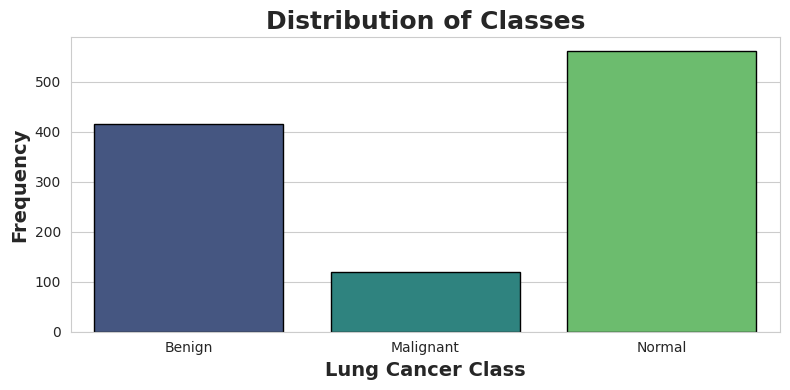

In [ ]:
#@title **2.2 Plotting the Lung Cancer Distribution Graph**

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

SIZE = (8, 4)

def plot_distribution(df, attribute, title, x_label, y_label, size=SIZE):
    # set a seaborn style for a more polished look
    sns.set_style("whitegrid")

    # adjust figure size
    plt.figure(figsize=size)

    # create the count plot with enhanced color palette and edge color
    sns.countplot(x=attribute, data=df, hue=attribute, palette="viridis", edgecolor='black', legend=False)

    # set labels and title with customized font sizes
    plt.xticks(ticks=plt.gca().get_xticks(), labels=[label.get_text().capitalize() for label in plt.gca().get_xticklabels()])
    plt.xlabel(x_label, fontsize=14, fontweight='bold')
    plt.ylabel(y_label, fontsize=14, fontweight='bold')
    plt.title(title, fontsize=18, fontweight='bold')

    # improve the layout
    plt.tight_layout()

    # show the plot
    plt.show()

attribute = 'labels'
title = 'Distribution of Classes'
x_label = 'Lung Cancer Class'
y_label = 'Frequency'

plot_distribution(df, attribute, title, x_label, y_label)

In medical datasets, data is scarce and readily available. This limited availability often leads to imbalanced distributions of images, which can result in biased or inaccurate model performance. For instance, if one class (Normal) significantly outnumbers other classes (Malignant or Benign), a model may struggle to detect the minority classes accurately (in this case Malignant or Benign), leading to poor generalization. This issue is particularly problematic in medical image classification tasks, where accurate detection of rare cases, such as early-stage cancer, is critical for diagnosis and treatment. Techniques like data augmentation, synthetic data generation, or resampling methods can help address these challenges by improving the model's ability to learn from limited and imbalanced data.

# **3. Preprocessing the Data**

In [ ]:
# @title **3.1 Preparing the data.**

# Import libraries

from sklearn.model_selection import train_test_split
from transformers import ViTImageProcessor
from tabulate import tabulate
from PIL import Image
import numpy as np
import random

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset


TEST_SIZE = 0.2  # @param {type:"number", description:"The proportion of the dataset to include in the test split"}
BATCH_SIZE = 2  # @param {type:"integer", description:"The number of samples to process in each batch"}
IMAGE_SIZE = 224 # @param {type:"integer", description:"The size of the image 224x224."}
NUM_WORKERS = 0  # @param {type:"integer", description:"The number of processes that generate batches in parallel."}

SEED = 42 #  param {type:"integer", description:"Seed for Randomization."}
MAX_SIZE = 256 # param {type:"integer", description:"The standard size of the image 256x256."}
SIZE = (IMAGE_SIZE, IMAGE_SIZE)  # 224x224

# ViT Image Processor
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
image_mean = processor.image_mean
image_std = processor.image_std
size = processor.size["height"]


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


def train_test_val_split(df, test_size=TEST_SIZE):
    train_set, remaining_df = train_test_split(df, test_size=0.4, random_state=SEED, stratify=df['labels'])
    test_set, val_set = train_test_split(remaining_df, test_size=0.5, random_state=SEED, stratify=remaining_df['labels'])

    data = [
        ["Train", train_set.shape],
        ["Test", test_set.shape],
        ["Validate", val_set.shape],
    ]

    X_table = tabulate(data, headers=["SETS", "Shape"], tablefmt="fancy_grid")
    print(X_table)

    return train_set, test_set, val_set


class LungCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]  # Get the file path
        image = Image.open(img_path).convert("RGB")  # Open the image file
        label = self.dataframe.iloc[idx, 1]  # Get the label
        if self.transform:  # Transform image if transformation is provided
            image = self.transform(image)
        label = label_to_ID[label]  # Convert label to tensor
        # Return as a dictionary
        return {"pixel_values": image, "label": label}


# Adapted from TinTn: https://github.com/tintn/vision-transformer-from-scratch
def prepare_transforms():
    train_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize(SIZE),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomResizedCrop(
                SIZE,
                scale=(0.8, 1.0),
                ratio=(0.75, 1.3333333333333333),
                interpolation=2,
            ),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    val_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize(SIZE),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    test_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize(SIZE),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    return train_transform, val_transform, test_transform


def prepare_data(df, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    # Define the transformation (resize, normalize, etc.)
    train_transform, val_transform, test_transform = prepare_transforms()

    # Create the datasets
    train_set = LungCancerDataset(train_df, transform=train_transform)
    val_set = LungCancerDataset(val_df, transform=val_transform)
    test_set = LungCancerDataset(test_df, transform=test_transform)

    def collate_fn(batch_samples):
        # Extract pixel values and labels from the batch
        batch_pixel_values = torch.stack([sample["pixel_values"] for sample in batch_samples])
        batch_labels = torch.tensor([sample["label"] for sample in batch_samples])
        return {"pixel_values": batch_pixel_values, "labels": batch_labels}

    # Create DataLoaders
    train = DataLoader(
        train_set, batch_size=batch_size, collate_fn=collate_fn, shuffle=True, num_workers=num_workers
    )
    val = DataLoader(
        val_set, batch_size=batch_size, collate_fn=collate_fn, shuffle=False, num_workers=num_workers
    )
    test = DataLoader(
        test_set, batch_size=batch_size, collate_fn=collate_fn, shuffle=False, num_workers=num_workers
    )

    return train, test, val


def display_loader_information(data_loader):
    batch = next(iter(data_loader))

    print()
    assert batch['pixel_values'].shape == (BATCH_SIZE, 3, 224, 224)
    assert batch['labels'].shape == (BATCH_SIZE,)

    for k, v in batch.items():
        if isinstance(v, torch.Tensor):
            print(f"{k}: {v.shape}")


seed_everything(SEED)

# Split the dataset using the train_test_split function
train_df, test_df, val_df = train_test_val_split(df)
train, test, val = prepare_data(df)

#**Checking the Data Loaders**
display_loader_information(train)
display_loader_information(test)
display_loader_information(val)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

╒══════════╤══════════╕
│ SETS     │ Shape    │
╞══════════╪══════════╡
│ Train    │ (658, 2) │
├──────────┼──────────┤
│ Test     │ (219, 2) │
├──────────┼──────────┤
│ Validate │ (220, 2) │
╘══════════╧══════════╛

pixel_values: torch.Size([2, 3, 224, 224])
labels: torch.Size([2])

pixel_values: torch.Size([2, 3, 224, 224])
labels: torch.Size([2])

pixel_values: torch.Size([2, 3, 224, 224])
labels: torch.Size([2])


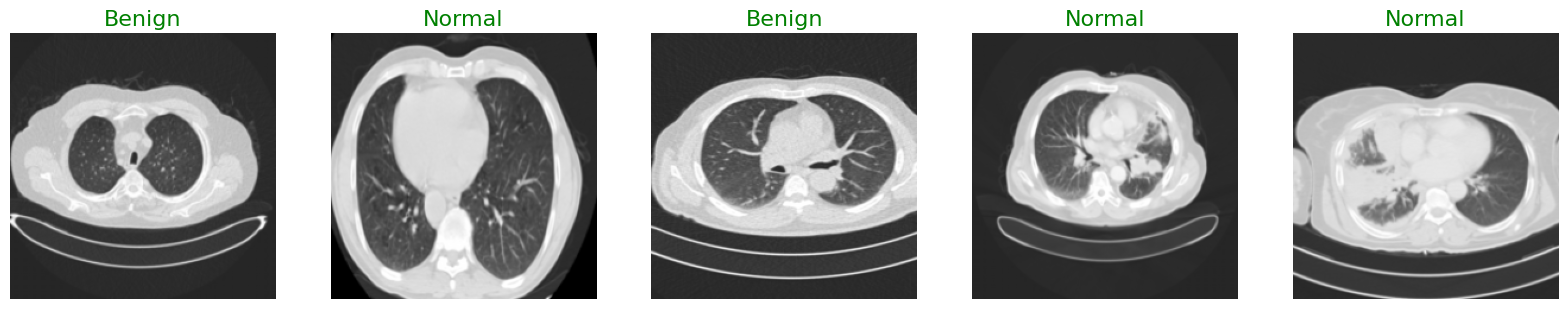

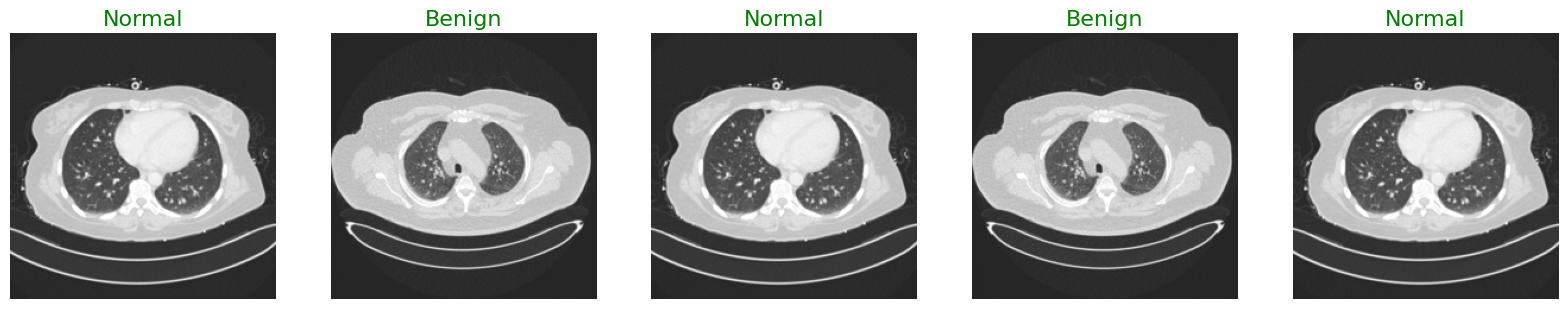

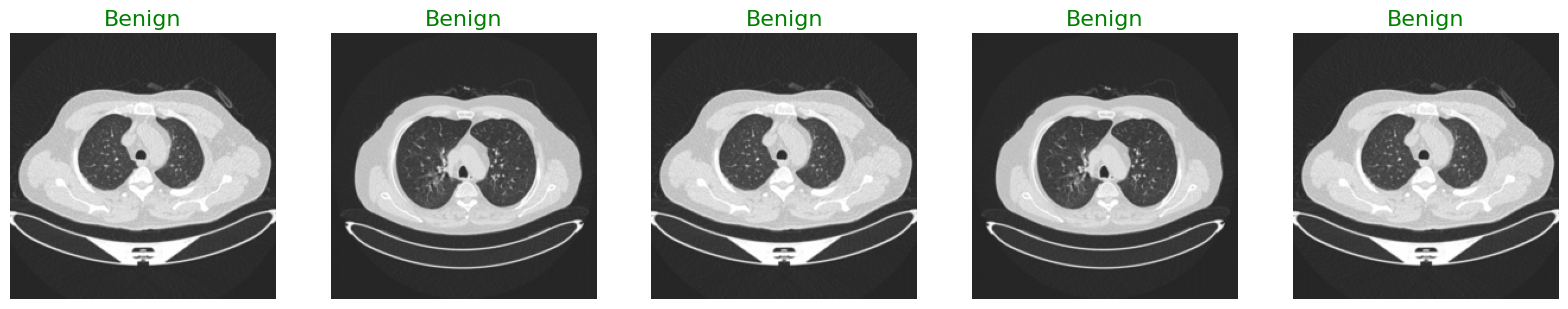

In [ ]:
#@title **3.2 Visualising the Data Loaders**

# Function to display sample images from multiple batches
def display_sample_images(data_loader, num_images=5):
    images_list, labels_list = [], []

    # Accumulate images until we get the desired number
    while len(images_list) < num_images:
        batch = next(iter(data_loader))  # Get the next batch (now a dict with "pixel_values" and "labels")
        images = batch["pixel_values"]  # Access the pixel values
        labels = batch["labels"]  # Access the labels
        images_list.append(images)
        labels_list.append(labels)

    # Concatenate the accumulated images and labels
    images = torch.cat(images_list, dim=0)
    labels = torch.cat(labels_list, dim=0)

    # Denormalize images (if normalized during training)
    images = images * torch.tensor(image_std).view(3, 1, 1) + torch.tensor(image_mean).view(3, 1, 1)

    # Clip values to [0, 1] range
    images = torch.clamp(images, 0, 1)

    # Convert images to NumPy for visualization
    images = images.numpy()

    # Setup the plot
    plt.figure(figsize=(20, 20))

    for i in range(min(num_images, len(labels))):
        plt.subplot(5, 5, i + 1)  # 5x5 grid for up to 25 images
        img = np.transpose(images[i], (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        plt.imshow(img)
        plt.title(f"{ID_to_label[labels[i].item()].capitalize()}", color="green", fontsize=16)
        plt.axis('off')

    plt.show()

# Visualizing 5 images from each loader
display_sample_images(train, num_images=5)
display_sample_images(test, num_images=5)
display_sample_images(val, num_images=5)

# **4. ViT Model Implementation**

## **4.1 Utilities**

In [ ]:
#@title **4.1 Training Parameters**

EXP_NAME = "ViT_base_finetuned" # @param {type:"string", description:"Description of this model."}
EPOCHS = 10 # @param {type:"integer", description:"Number of epochs to train model."}
NUM_CLASSES = 3 # @param {type:"integer", description:"Number of classes for classification."}
PATCH_SIZE = 32 # @param {type:"integer", description:"The size of the patches into which the input image is divided. 32x32"}
LEARNING_RATE = 5e-5 # @param {type:"number", description:"Learning rate."}
GAMMA = 0.0 # @param {type:"number", description:"Decay learning rate by this value."}

# PATCH_SIZE Calculation: (224/16)x(224/16) = 14×14 = 196 Patches

In [ ]:
#@title **4.2 Confusion Matrix**

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, labels, exp_name="Experiment"):
    """
    Plots a confusion matrix using seaborn's heatmap.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        labels (list): List of label names.
        exp_name (str): Name of the experiment, used in the plot title and saved file name.
    """
    # Generate the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Set the figure size and resolution
    plt.figure(figsize=(10, 8), dpi=100)

    # Create a custom color map
    cmap = sns.diverging_palette(220, 20, as_cmap=True)

    # Plot the confusion matrix heatmap
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap=cmap,
        linewidths=0.5,
        square=True,
        cbar_kws={"shrink": 0.75},
        xticklabels=[label.capitalize() for label in labels],
        yticklabels=[label.capitalize() for label in labels]
    )

    # Add labels and title with increased font size
    plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=14, fontweight='bold')
    plt.title(f'Confusion Matrix for {exp_name}', fontsize=16, fontweight='bold')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.tight_layout()
    plt.show()

    # Save the plot as a PNG file
    plt.savefig(f"{exp_name}_Confusion_Matrix_Heatmap.png", format='png', dpi=300)

### **4.3 Misclassification Handling**

#### **4.3.1 Visualising Misclassification - Distribution Graphs for Dataframes**

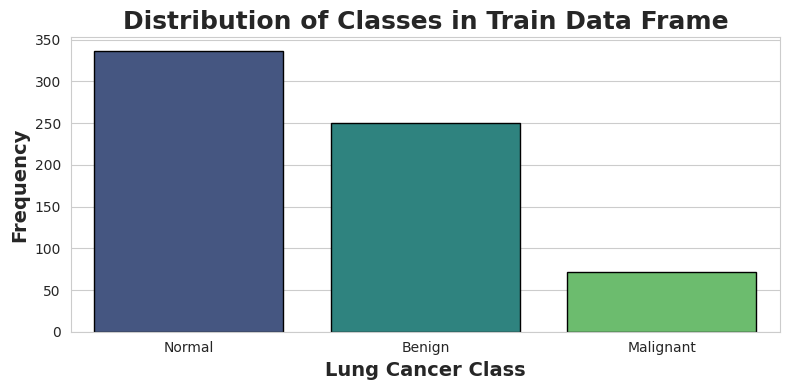

In [ ]:
#@title **(a) Distribution Graph: train_df**
attribute = 'labels'
title = 'Distribution of Classes in Train Data Frame'
x_label = 'Lung Cancer Class'
y_label = 'Frequency'

plot_distribution(train_df, attribute, title, x_label, y_label)

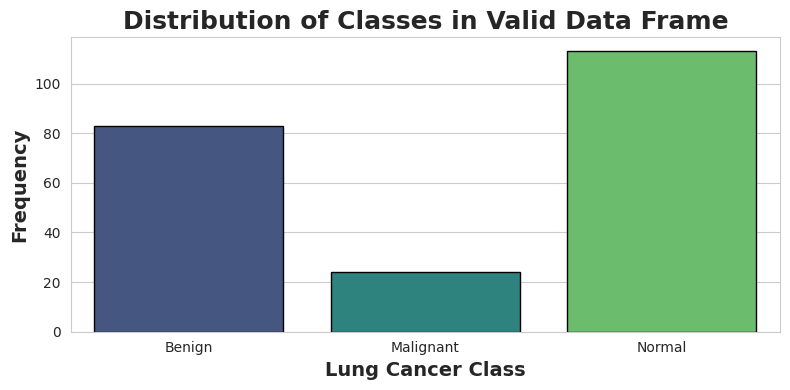

In [ ]:
#@title **(b) Distribution Graph: val_df**
attribute = 'labels'
title = 'Distribution of Classes in Valid Data Frame'
x_label = 'Lung Cancer Class'
y_label = 'Frequency'

plot_distribution(val_df, attribute, title, x_label, y_label)

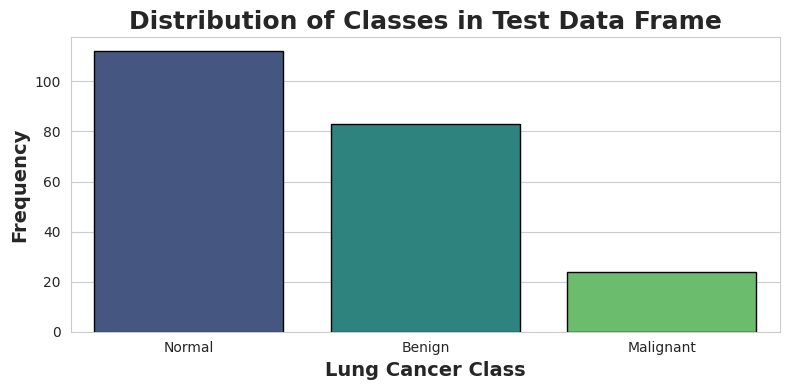

In [ ]:
#@title **(c) Distribution Graph: test_df**
attribute = 'labels'
title = 'Distribution of Classes in Test Data Frame'
x_label = 'Lung Cancer Class'
y_label = 'Frequency'

plot_distribution(test_df, attribute, title, x_label, y_label)

#### **4.3.2 Handling Misclassification**

**How to handle the imbalance of the distrbution of classes?**
We can compute weights for the Loss Function,

In [ ]:
from collections import Counter
import torch

# NOTE:
# need to recalculate weights for optimizer
# Convert label to tensor (use the same label mapping)
# label_to_ID = {"benign": 0, "malignant": 1, "normal": 2}
# ID_to_label = {0: "benign", 1: "malignant", 2: "normal"}

# Initialised Early - Needed for Misclassification Handling
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_weights(df):
    labels = df.iloc[:, 1].map(label_to_ID)
    label_counts = Counter(labels)
    total_samples = len(labels)
    print(f"Label Frequencies in Dataframe: {label_counts}")

    num_classes = len(label_to_ID)
    class_weights = []

    # Calculate the weight for each class (inversely proportional to its frequency)
    for ID in label_counts.keys():
        class_weight = total_samples / (num_classes * label_counts[ID])
        class_weights.append(class_weight)

    # Convert to a PyTorch Tensor
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
    print(f"Class Weights: {class_weights}\n")

    return class_weights

# higher weights are assigned to labels with lower count
train_weights = get_weights(train_df)
val_weights = get_weights(val_df)
test_weights = get_weights(test_df)

def get_universal_weight():
    # Average the weights from training, validation, and testing
    universal_weight = (train_weights + val_weights + test_weights) / 3
    print(f"Universal Class Weights: {universal_weight}")
    return universal_weight

universal_weight = get_universal_weight()

Label Frequencies in Dataframe: Counter({2: 336, 0: 250, 1: 72})
Class Weights: tensor([0.6528, 0.8773, 3.0463], device='cuda:0')

Label Frequencies in Dataframe: Counter({2: 113, 0: 83, 1: 24})
Class Weights: tensor([0.8835, 3.0556, 0.6490], device='cuda:0')

Label Frequencies in Dataframe: Counter({2: 112, 0: 83, 1: 24})
Class Weights: tensor([0.6518, 0.8795, 3.0417], device='cuda:0')

Universal Class Weights: tensor([0.7294, 1.6041, 2.2456], device='cuda:0')


## **4.2 ViT Model Implementation - Fine Tuned**

In [ ]:
import torchmetrics
import pytorch_lightning as pl
import torch.nn as nn
import torch.optim as optim
from transformers import ViTForImageClassification, AdamW

class ViTLightningModule(pl.LightningModule):
    def __init__(self, num_labels=NUM_CLASSES):
        super(ViTLightningModule, self).__init__()
        self.vit = ViTForImageClassification.from_pretrained(
            "google/vit-base-patch16-224-in21k",
            num_labels=NUM_CLASSES,
            id2label=ID_to_label,
            label2id=label_to_ID,
        )

        self.criterion = nn.CrossEntropyLoss(weight=universal_weight)

        # Define metrics
        self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES, average='macro')
        self.train_precision = torchmetrics.Precision(task="multiclass", num_classes=NUM_CLASSES, average='macro')
        self.train_recall = torchmetrics.Recall(task="multiclass", num_classes=NUM_CLASSES, average='macro')
        self.train_f1 = torchmetrics.F1Score(task="multiclass", num_classes=NUM_CLASSES, average='macro')
        self.train_auc = torchmetrics.AUROC(task="multiclass", num_classes=NUM_CLASSES)

        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES, average='macro')
        self.val_precision = torchmetrics.Precision(task="multiclass", num_classes=NUM_CLASSES, average='macro')
        self.val_recall = torchmetrics.Recall(task="multiclass", num_classes=NUM_CLASSES, average='macro')
        self.val_f1 = torchmetrics.F1Score(task="multiclass", num_classes=NUM_CLASSES, average='macro')
        self.val_auc = torchmetrics.AUROC(task="multiclass", num_classes=NUM_CLASSES)

        self.test_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES, average='macro')
        self.test_precision = torchmetrics.Precision(task="multiclass", num_classes=NUM_CLASSES, average='macro')
        self.test_recall = torchmetrics.Recall(task="multiclass", num_classes=NUM_CLASSES, average='macro')
        self.test_f1 = torchmetrics.F1Score(task="multiclass", num_classes=NUM_CLASSES, average='macro')
        self.test_auc = torchmetrics.AUROC(task="multiclass", num_classes=NUM_CLASSES)
        self.confusion_matrix = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=NUM_CLASSES)

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        return outputs.logits

    def common_step(self, batch, batch_idx, stage="train"):
        pixel_values = batch["pixel_values"]
        labels = batch["labels"]
        logits = self(pixel_values)
        loss = self.criterion(logits, labels)
        predictions = logits.argmax(-1)

        if stage == "train":
            self.train_accuracy(predictions, labels)
            self.train_precision(predictions, labels)
            self.train_recall(predictions, labels)
            self.train_f1(predictions, labels)
            self.train_auc(logits, labels)
        elif stage == "val":
            self.val_accuracy(predictions, labels)
            self.val_precision(predictions, labels)
            self.val_recall(predictions, labels)
            self.val_f1(predictions, labels)
            self.val_auc(logits, labels)
        elif stage == "test":
            self.test_accuracy(predictions, labels)
            self.test_precision(predictions, labels)
            self.test_recall(predictions, labels)
            self.test_f1(predictions, labels)
            self.test_auc(logits, labels)
            self.confusion_matrix(predictions, labels)

        return loss

    def training_step(self, batch, batch_idx):
        loss = self.common_step(batch, batch_idx, stage="train")

        # Log metrics for training
        self.log("train_loss", loss)
        self.log("train_accuracy", self.train_accuracy, on_epoch=True)
        self.log("train_precision", self.train_precision, on_epoch=True)
        self.log("train_recall", self.train_recall, on_epoch=True)
        self.log("train_f1", self.train_f1, on_epoch=True)
        self.log("train_auc", self.train_auc, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.common_step(batch, batch_idx, stage="val")

        # Log metrics for validation
        self.log("val_loss", loss, on_epoch=True)
        self.log("val_accuracy", self.val_accuracy, on_epoch=True)
        self.log("val_precision", self.val_precision, on_epoch=True)
        self.log("val_recall", self.val_recall, on_epoch=True)
        self.log("val_f1", self.val_f1, on_epoch=True)
        self.log("val_auc", self.val_auc, on_epoch=True)

        return loss

    def test_step(self, batch, batch_idx):
        loss = self.common_step(batch, batch_idx, stage="test")

        # Log and print test metrics
        self.log("test_loss", loss, on_epoch=True)
        self.log("test_accuracy", self.test_accuracy, on_epoch=True)
        self.log("test_precision", self.test_precision, on_epoch=True)
        self.log("test_recall", self.test_recall, on_epoch=True)
        self.log("test_f1", self.test_f1, on_epoch=True)
        self.log("test_auc", self.test_auc, on_epoch=True)

        return loss

    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=LEARNING_RATE)

    def train_dataloader(self):
        return train

    def val_dataloader(self):
        return val

    def test_dataloader(self):
        return test

    def print_cm(self):
        conf_matrix = self.confusion_matrix.compute().cpu().numpy()

        # Set the figure size and resolution
        plt.figure(figsize=(10, 8), dpi=100)

        # Create a custom color map
        cmap = sns.diverging_palette(220, 20, as_cmap=True)

        # Plot the confusion matrix heatmap
        sns.heatmap(
            conf_matrix,
            annot=True,
            fmt="d",
            cmap=cmap,
            linewidths=0.5,
            square=True,
            cbar_kws={"shrink": 0.75},
            xticklabels=[label.capitalize() for label in label_to_ID.keys()],
            yticklabels=[label.capitalize() for label in label_to_ID.keys()]
        )

        # Add labels and title with increased font size
        plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
        plt.ylabel('True Label', fontsize=14, fontweight='bold')
        plt.title('Confusion Matrix for ' + EXP_NAME, fontsize=16, fontweight='bold')
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12, rotation=0)
        plt.tight_layout()
        plt.show()
        plt.savefig(EXP_NAME + '_Confusion_Matrix_Heatmap.png', format='png', dpi=300)

# **5. Training the Model**

In [ ]:
#@title **5.1 ViT Model Training**

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor

# Define callbacks
early_stop_callback = EarlyStopping(
    monitor='val_loss',    # Ensure this matches the metric you're logging in your validation_epoch_end
    patience=10,           # Adjust patience as needed
    mode='min',            # Minimize the validation loss
    verbose=True           # Set to True to get messages in the logs
)

model_checkpoint = ModelCheckpoint(
    dirpath='./',           # Directory where model checkpoints will be saved
    filename='best_model',  # Filename for the checkpoint
    monitor='val_loss',     # Metric to monitor
    save_top_k=1,           # Save only the best model
    mode='min'              # Save the model with minimum validation loss
)

# Set up TensorBoard logging
tensorboard_logger = TensorBoardLogger(
    save_dir='./logs',     # Directory for logs
    name=EXP_NAME,         # Name of the subdirectory for logs
    version=1              # Version number for the logs
)

# Create model instance
model = ViTLightningModule()

# Initialize the Trainer with callbacks
trainer = Trainer(
    max_epochs=EPOCHS,
    logger=tensorboard_logger,  # Add TensorBoard logger
    log_every_n_steps=1,        # Log every step (optional)
    callbacks=[early_stop_callback, model_checkpoint],
)

# Train the model
trainer.fit(model)

# Save the model checkpoint
trainer.save_checkpoint("fine_tuned_vit_model.ckpt")

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name             | Type                      | Params | Mode 
------------------------------------------------------------------------
0  | vit              | ViTForI

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.426


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.109 >= min_delta = 0.0. New best score: 0.317


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 0.280


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.068 >= min_delta = 0.0. New best score: 0.212


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.186


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


# **6. Evaluating the Model**

In [ ]:
#@title **6.1 Test Model**

trainer.test()

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/best_model.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/best_model.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8223250508308411     │
│         test_auc          │    0.9770104289054871     │
│          test_f1          │    0.8474496006965637     │
│         test_loss         │    0.19450323283672333    │
│      test_precision       │    0.9062817096710205     │
│        test_recall        │    0.8223250508308411     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.19450323283672333,
  'test_accuracy': 0.8223250508308411,
  'test_precision': 0.9062817096710205,
  'test_recall': 0.8223250508308411,
  'test_f1': 0.8474496006965637,
  'test_auc': 0.9770104289054871}]

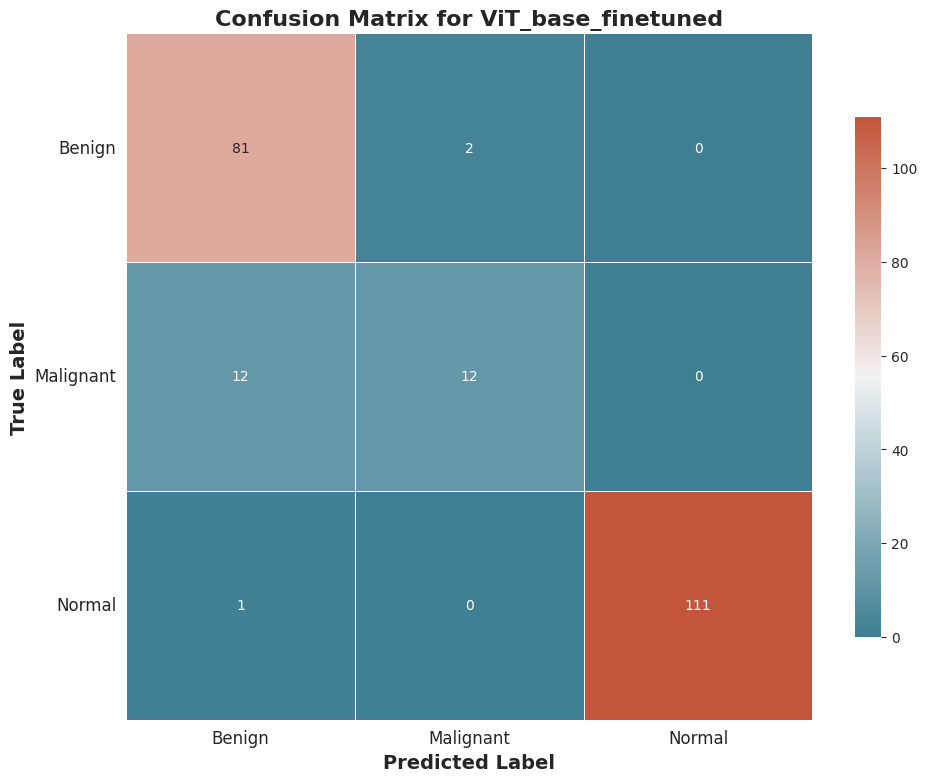

<Figure size 640x480 with 0 Axes>

In [ ]:
#@title **6.2 Confusion Matrix**

model.print_cm()

# **7. Downloading the Model**

In [ ]:
import torch

# Define the path where you want to save the model
model_save_path = EXP_NAME + "_Model.pth"

# Save the model state dictionary
torch.save(model.state_dict(), model_save_path)

# zip the important folders
!zip -r /content/ViT_base_finetuned_Model.zip /content/ViT_base_finetuned_Model.pth

!mkdir -p /content/drive/MyDrive/Research  # Create the folder if it doesn't exist
!mv /content/ViT_base_finetuned_Confusion_Matrix_Heatmap.png /content/drive/MyDrive/Research
!mv /content/ViT_base_finetuned_Model.zip /content/drive/MyDrive/Research

  adding: content/ViT_base_finetuned_Model.pth (deflated 7%)


In [ ]:
!zip -r /content/ViT_base_finetuned_logs.zip /content/logs
!mkdir -p /content/drive/MyDrive/Research  # Create the folder if it doesn't exist
!mv /content/ViT_base_finetuned_logs.zip /content/drive/MyDrive/Research

  adding: content/logs/ (stored 0%)
  adding: content/logs/ViT_base_finetuned/ (stored 0%)
  adding: content/logs/ViT_base_finetuned/version_1/ (stored 0%)
  adding: content/logs/ViT_base_finetuned/version_1/events.out.tfevents.1730496131.4acfe33cc369.467.0 (deflated 77%)
  adding: content/logs/ViT_base_finetuned/version_1/events.out.tfevents.1730496771.4acfe33cc369.467.1 (deflated 27%)
  adding: content/logs/ViT_base_finetuned/version_1/hparams.yaml (stored 0%)


In [ ]:
!zip -r /content/ViT_base_finetuned_best_model.zip /content/best_model.ckpt
!zip -r /content/ViT_base_finetuned_cktp.zip /content/fine_tuned_vit_model.ckpt

!mkdir -p /content/drive/MyDrive/Research  # Create the folder if it doesn't exist
!mv /content/ViT_base_finetuned_best_model.zip /content/drive/MyDrive/Research
!mv /content/ViT_base_finetuned_cktp.zip /content/drive/MyDrive/Research

  adding: content/best_model.ckpt (deflated 8%)
  adding: content/fine_tuned_vit_model.ckpt (deflated 8%)
